In [1]:
import os
import keras_cv
import tensorflow as tf
from tensorflow import keras



Using TensorFlow backend


c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SPLIT_RATIO = 0.08
BATCH_SIZE = 8
LEARNING_RATE = 0.01
EPOCH = 15
GLOBAL_CLIPNORM = 10.0

In [3]:
class_ids = [
    "belcebu",
    "mazapan",
    "nina",
    "uxia"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

bounding_box_format = "rel_xywh"

path_dataset = "updated-images-and-labels"
path_weights = "last.keras"

annotations = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".txt")
    ]
)

images = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".jpg")
    ]
)

assert len(images) == len(annotations)

In [4]:
classes = []
boxes = []
for annotation_path in annotations:
	classes_for_img = []
	boxes_for_img = []
	with open(annotation_path) as annotation_file:
		for line in annotation_file.readlines():
			classes_for_img.append(int(line.split(' ')[0]))
			boxes_for_img.append([float(n) for n in line.strip().split(' ')[1:]])
	classes.append(classes_for_img)
	boxes.append(boxes_for_img)
boxes = tf.ragged.constant(boxes)
classes = tf.ragged.constant(classes)
images = tf.ragged.constant(images)

data = tf.data.Dataset.from_tensor_slices((images, classes, boxes))

num_val = int(len(images) * SPLIT_RATIO)

print(f"using {num_val} images for validation")
print(f"using {len(images) - num_val} images for training")

val_data = data.take(num_val)
train_data = data.skip(num_val)


using 70 images for validation
using 808 images for training


In [5]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

def visualize_dataset(inputs, value_range, rows, cols):
    inputs = next(iter(inputs.take(1)))
    
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
	

    keras_cv.visualization.plot_bounding_box_gallery(
        images=images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_pred=bounding_boxes,
        scale=3,
        font_scale=1.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format=bounding_box_format
)

In [6]:
train_ds = (train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(BATCH_SIZE * 4)
               .ragged_batch(BATCH_SIZE, drop_remainder=True)
.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE))

val_ds = (val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(BATCH_SIZE * 4)
               .ragged_batch(BATCH_SIZE, drop_remainder=True)
.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE))


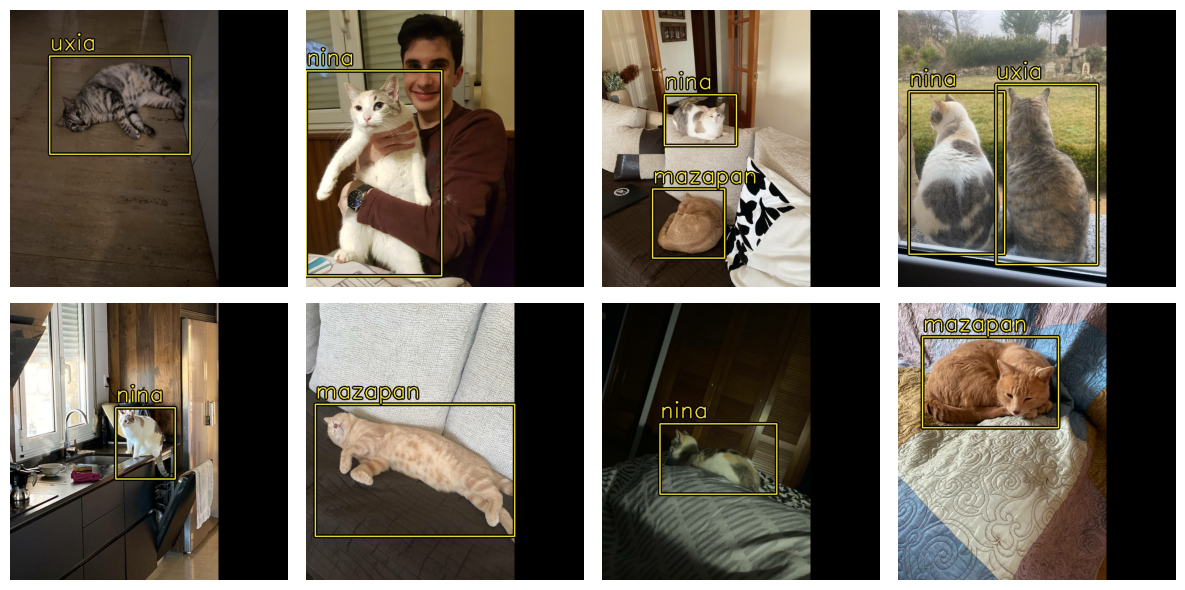

In [7]:
visualize_dataset(inputs=train_ds, value_range=(0,255), rows=2,cols=4)

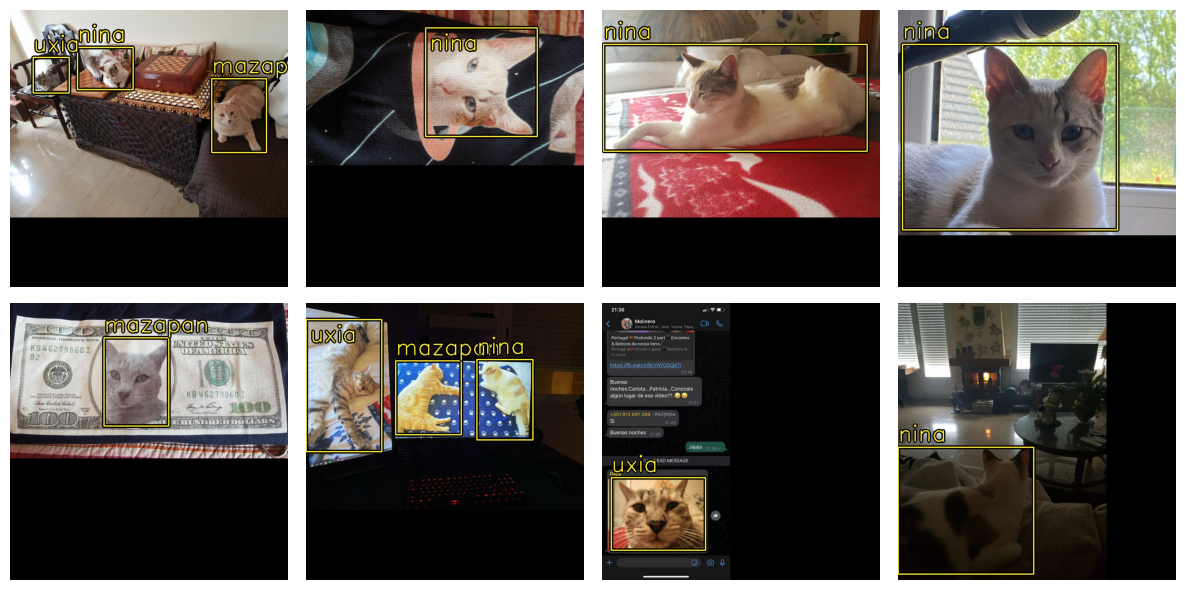

In [8]:
visualize_dataset(inputs=val_ds, value_range=(0,255), rows=2,cols=4)

In [9]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco"
    )

backbone.trainable = False
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_ids),
    bounding_box_format=bounding_box_format,
    backbone=backbone,
    fpn_depth=2
)

yolo.compile(
    classification_loss='binary_crossentropy',
    box_loss='ciou',
    optimizer=tf.optimizers.SGD(global_clipnorm=GLOBAL_CLIPNORM, learning_rate=LEARNING_RATE),
    jit_compile=False,
)
yolo.fit(train_ds, validation_data=val_ds, epochs=EPOCH)

101/101 [==============================] - 468s 4s/step - loss: 112.2310 - box_loss: 2.5970 - class_loss: 109.6340 - val_loss: 9.6883 - val_box_loss: 2.5093 - val_class_loss: 7.1790


1/1 [==============================] - 7s 7s/step


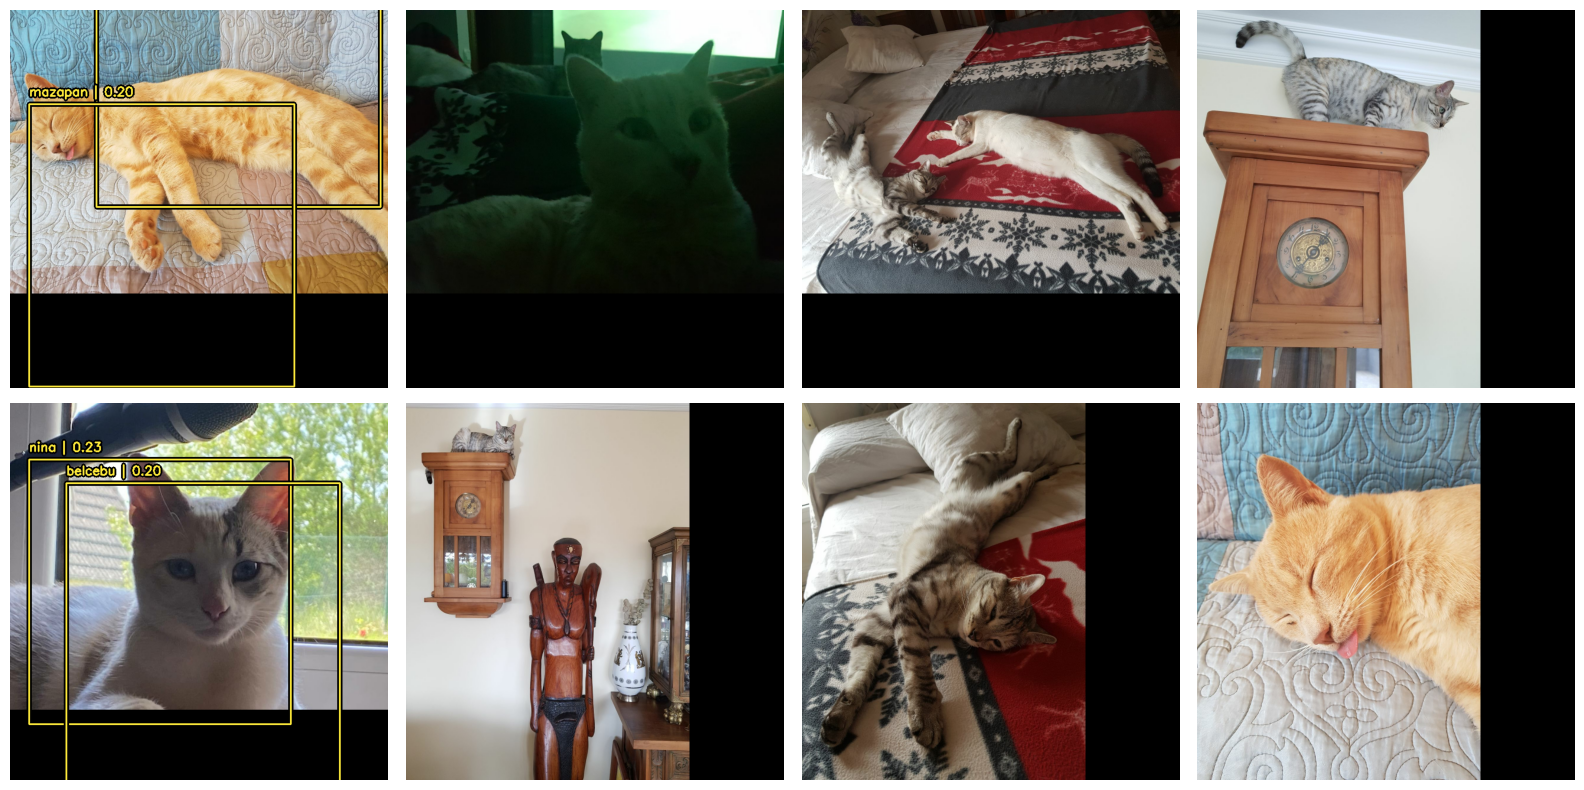

In [11]:
def visualize_detections(model, dataset):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds)

In [13]:
metrics = keras_cv.metrics.BoxCOCOMetrics(bounding_box_format=bounding_box_format, evaluate_freq=1)

for batch in val_ds:
    images, y_true = batch[0], batch[1]
    y_pred = yolo.predict(images, verbose=0)
    metrics.update_state(y_true, y_pred)

print(metrics.result()["MaP"])

InvalidArgumentError: {{function_node __wrapped__EagerPyFunc_Tin_8_Tout_0_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: convert_format() must receive `images` or `image_shape` when transforming between relative and absolute formats.convert_format() received source=`<built-in function format>`, target=`<built-in function format>, but images=None and image_shape=None.
Traceback (most recent call last):

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\bounding_box\converters.py", line 425, in convert_format
    in_xyxy = to_xyxy_fn(boxes, images=images, image_shape=image_shape)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\bounding_box\converters.py", line 161, in _rel_xywh_to_xyxy
    image_height, image_width = _image_shape(images, image_shape, boxes)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\bounding_box\converters.py", line 514, in _image_shape
    raise RequiresImagesException()

keras_cv.bounding_box.converters.RequiresImagesException


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 266, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 144, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 151, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 810, in wrapped_func
    out = func(*structured_inp)
          ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\metrics\object_detection\box_coco_metrics.py", line 171, in update_state_on_cpu
    return obj_update_state(y_true, y_pred, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\metrics\object_detection\box_coco_metrics.py", line 244, in update_state
    self._cached_result = self._compute_result()
                          ^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\metrics\object_detection\box_coco_metrics.py", line 261, in _compute_result
    metrics = compute_pycocotools_metric(
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\metrics\object_detection\box_coco_metrics.py", line 284, in compute_pycocotools_metric
    box_pred = bounding_box.convert_format(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\backend\scope.py", line 37, in wrapper
    return function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\lagam\Documents\final-bootcamp-project\.venv\Lib\site-packages\keras_cv\bounding_box\converters.py", line 428, in convert_format
    raise ValueError(

ValueError: convert_format() must receive `images` or `image_shape` when transforming between relative and absolute formats.convert_format() received source=`<built-in function format>`, target=`<built-in function format>, but images=None and image_shape=None.

 [Op:EagerPyFunc] name: 